# Setup

In [3]:
from utils.models import random_forest, log_reg, knn, xgboost
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib
import pandas as pd
from utils.plot import evaluation_metrics, evaluation_metric
from utils.model import get_cleaned_data, split_train_test, finetune_model
data = get_cleaned_data("./data/kickstarter_projects.csv")
xtrain,xtest,ytrain,ytest = split_train_test(data, "success")

# Model fitting 

           Model  Accuracy Score  Precision Score  Recall Score  F1 Score
0            knn            0.85             0.82          0.75      0.78
1        log_reg            0.90             0.92          0.80      0.86
2  random_forest            0.78             0.91          0.44      0.59


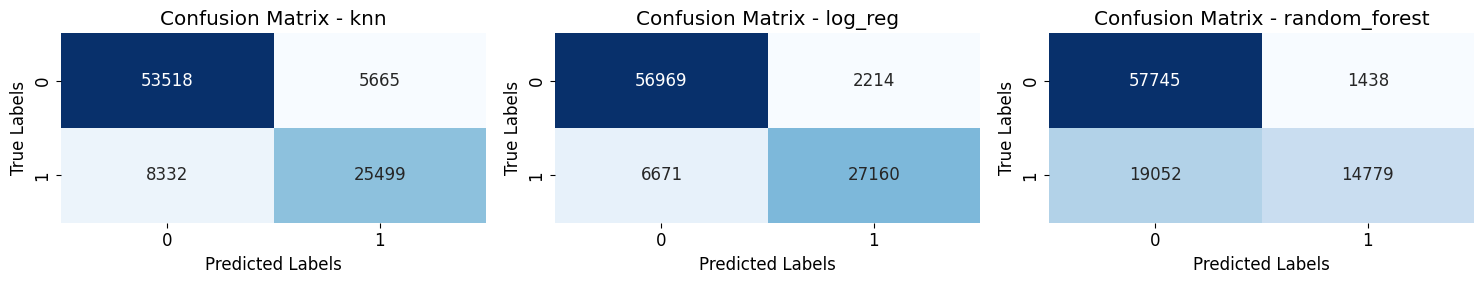

In [15]:
knn.fit(xtrain,ytrain)
log_reg.fit(xtrain,ytrain)
random_forest.fit(xtrain,ytrain)
evaluation_metrics([("knn",knn),("log_reg",log_reg), ("random_forest",random_forest)],xtest,ytest)

In [ ]:
model = VotingClassifier(estimators=[("knn",knn),("log_reg",log_reg), ("random_forest",random_forest)], voting="soft")
model.fit(xtrain,ytrain)
#joblib.dump(model, './utils/pickles/ensemble.joblib')
evaluation_metrics([("ensemble", model),("knn",knn),("log_reg",log_reg),("random_forest",random_forest)],xtest, ytest)

In [7]:
# Making a prediction

project = pd.DataFrame([{
    "country": "Germany",
    "goal":100000,
    "category": "Theater",
    "subcategory": "Festivals",
    "launched": "2024-05-24",
    "deadline": "2024-08-25",
    "name":"test",
    "backers":0
}])

print(model.predict(project))
print(model.predict_proba(project))

[0]
[[0.91952894 0.08047106]]


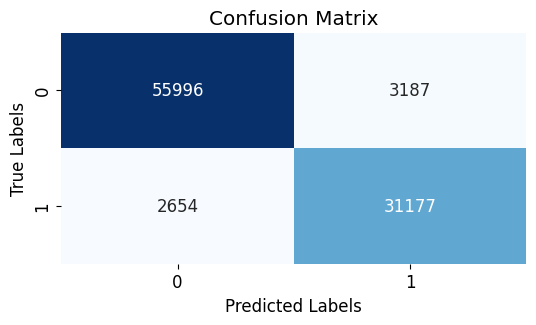

--------------------------------------------------------------------------------
Accuracy Score :  0.94  Precision Score :  0.91  Recall Score :  0.92 , F1 Score :  0.91
--------------------------------------------------------------------------------



----------------  Classification Report  ----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     59183
           1       0.91      0.92      0.91     33831

    accuracy                           0.94     93014
   macro avg       0.93      0.93      0.93     93014
weighted avg       0.94      0.94      0.94     93014



In [16]:
#xgboost
xgboost.fit(xtrain,ytrain)
ypred = xgboost.predict(xtest)
evaluation_metric(ytest, ypred)

# Model finetuning

We perform model hyperparameter finetuning on XGBoost i.e the best performing model.

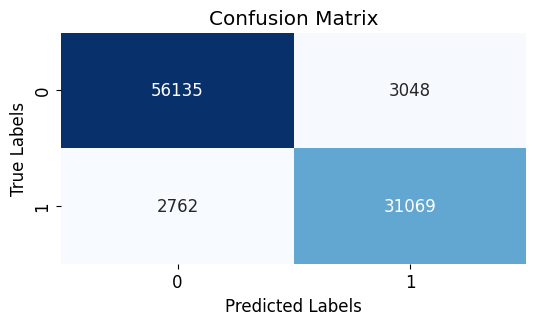

--------------------------------------------------------------------------------
Accuracy Score :  0.94  Precision Score :  0.91  Recall Score :  0.92 , F1 Score :  0.91
--------------------------------------------------------------------------------



----------------  Classification Report  ----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     59183
           1       0.91      0.92      0.91     33831

    accuracy                           0.94     93014
   macro avg       0.93      0.93      0.93     93014
weighted avg       0.94      0.94      0.94     93014



In [5]:
param_dist = {
    'xgb__n_estimators': [50, 100, 150, 200, 250, 300],  # Number of boosting rounds
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],   # Step size shrinkage
    'xgb__max_depth': [3, 4, 5, 6, 7, 8],                 # Maximum depth of trees
    'xgb__min_child_weight': [1, 2, 3, 4, 5],             # Minimum sum of instance weight (hessian) needed in a child
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],          # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],   # Subsample ratio of columns for each tree
    'xgb__gamma': [0, 0.1, 0.2, 0.3, 0.4],               # Minimum loss reduction required to make a further partition
    'xgb__reg_alpha': [0, 0.1, 0.5, 1, 10],               # L1 regularization term on weights
    'xgb__reg_lambda': [0.1, 0.5, 1, 2, 3]                # L2 regularization term on weights
}
random_search = RandomizedSearchCV(
    xgboost, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of different combinations to test
    cv=5,       # Number of cross-validation folds
    scoring='accuracy',
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Fit the RandomizedSearchCV object
random_search.fit(xtrain, ytrain)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Predict on the test set with the best model
ypred = best_model.predict(xtest)
joblib.dump(best_model, './utils/pickles/xgboost.joblib')

evaluation_metric(ytest, ypred)